# **Projet de dimensionnement de stockage embarqué dans un tramway**

Baptiste Braun-Delvoye  
Dan Calamia  
Judicaël Corpet

### **Mise en place du modèle du système**

### **1) Système simulé sans batterie**

Importation des bibliothèques et initialisation des données :

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import random

#%% Création et conversion des données
NB_SIMU= 1000
VLAC = 750 #Volts
VSST = 790 #Volts
RSST = 33*1e-3 #mOhm
RHOLAC = 95e-6 # Ohm/m
RHORAIL = 10e-6 # Ohm/m

Times = []
X = []
V = [] #km/h-1 vitesse du train à déterminer avec le fichier marche_train.txt
Acc = [] #km/h-2 accélération du train à déterminer avec le fichier marche_train.txt
RLAC1 = [] # Résistance de la LAC entre la sous-station 1 et le train (valeurs dépendante de x)
RLAC2 = [] # Résistance de la LAC entre la sous-station 2 et le train (valeurs dépendante de x)
Rrail1 = [] # Résistance du rail entre la sous-station 1 et le train (valeurs dépendante de x)
Rrail2 = [] # Résistance du rail entre la sous-station 2 et le train (valeurs dépendante de x)
R1 = [] # Résistance équivalente pour la partie supérieure du schéma de Thévenin, traversée par le courant I1 (dépend de x)
R2 = [] # Résistance équivalente pour la partie inférieure du schéma de Thévenin, traversée par le courant I2 (dépend de x)
Req = [] # Résistance équivalente totale du schéma de Thévenin (dépend de x)
PLAC = [] #Puissance de la LAC (dépend de x)
Vtrain = [] #Tension du train à tout instant (dépend de x)
Itrain = [] #Intensité aux bornes du train à tout moment (dépend de x)
I1 = [] #Intensité de la partie supérieure du schéma de Thévenin
I2 = [] #Intensité de la partie inférieure du schéma de Thévenin

alpha = 0 # angle de la pente du chemin - toujours nul pour l'instant
M = 70*1e3 #tonnes masse du train
A0 = 780 #N constante forces
A1 = 6.4*1e-3 #N/tonnes constante accélération
B0 = 0.0 # constante nulle ?
B1 = 0.14*3600/(1e3*1e3) #N/tonnes/(km•h-1) constante
C0 = 0.3634*(3600**2)/(1e3*1e6) #N/tonnes/(km•h-1)^2 constante inverse vitesse
C1 = 0.0

Définition de fonctions qui nous aiderons à aller plus vite dans le code au fur et à mesure du projet (Ces fonctions sont enregistrées normalement dans un fichier auquel nous faisons appel) :

In [168]:
def readlist(file) : return list(map(float,file.readline().split()))
#Cette fonction permet simplement de lire une ligne d'un fichier et d'enregister chaque valeur
# séparé par un espace comme variable

def get_T_X(filename):
    """Permet de sortir du fichier donné les listes de valeurs du temps et de la position

    Args:
        filename (string): Nom du fichier à traiter

    Returns:
        tuple: Ensemble des listes créées
    """
    Times = []
    X = []
    
    file = open(filename, 'r')
    readedlist = readlist(file)
    
    while readedlist:
        Time, Position = readedlist
        Times.append(Time)
        X.append(Position)
        readedlist = readlist(file)
    return np.array(Times), np.array(X)

def get_V(Times, X):
    """Permet de calculer la vitesse en fonction du temps et de la postion. 
    Le calcul est basé sur les élémebts finis. 
    Ordre 2 lorsque nous sommes aux extrémités des listes et ordre 4 sinon pour une meilleure précision. 
    À prendre en compte que la fonction np.gradient() fait exactement la même chose mais comme nous avons créé nos fonctions avant d'avoir vu cela autant utiliser notre version.

    Args:
        Times (list): Liste des valeurs du temps
        X (list): Liste des valeurs de la position

    Returns:
        list: Liste des vitesses
    """
    taille = len(X)
    
    V = []
    
    V.append(0)
    for i in range(taille - 1):
        if i<2 or i>taille-3:
            v = (X[i+1]-X[i])/(Times[i+1]-Times[i])
        else:
            v = (X[i-2] - 8*X[i-1] + 8*X[i+1] - X[i+2])/(12*(Times[i+1]-Times[i]))
        V.append(v)

    V = np.array(V) 
    return V

def get_Acc(Times,V):
    """Prmet de calculer l'accélération en fonction de la vitesse et du temps. 
    On aurait aussi pu utiliser la position avec les différences finies de dérivée seconde. 
    Différence finie d'ordre 2 aux extrémités des listes, ordre 4 sinon.

    Args:
        Times (list): Liste des valeurs du temps
        V (list): Liste des valeurs de la vitesse

    Returns:
        list: Liste des valeurs de l'accélération
    """
    taille = len(V)
    
    Acc = []
    
    Acc.append(0)
    for i in range(taille-1):
        if i<2 or i>taille-3:
            a = (V[i+1]-V[i])/(Times[i+1]-Times[i])
        else:
            a = (V[i-2] - 8*V[i-1] + 8*V[i+1] - V[i+2])/(12*(Times[i+1]-Times[i]))
        Acc.append(a)

    Acc = np.array(Acc)
    return Acc

def methode_trapeze(f):
    """Méthode des trapèzes pour calculer une intégrale, utiliser pour le calcul de l'énergie de la batterie.

    Args:
        f (list): Fonction à intégrer

    Returns:
        float: Valeur de l'intégrale de la fonction
    """
    somme = 0
    for i in range(1,len(f)-1):
        h=1
        a=(i-1)*h
        b=i*h
        # for j in range(a,b):
        aire=(f[i]+f[i-1])*(b-a)/2
        somme+=aire
        a+=h
        # res.append(somme)   
    return somme

Ajout des données du fichier "marche_train.txt" :

In [169]:
FICHIER = "marche_train.txt" # nom du fichier dans le dossier

Times, X = get_T_X(FICHIER)

Calcul de la vitesse, de l'accélération, des forces et de la puissance :

In [170]:
V = get_V(Times, X)

Acc = get_Acc(Times, V)

FR = (A0 + A1*M) + (B0 + B1*M)*V + (C0 + C1*M)*V**2 # Force resistive

Fm = M*Acc + M*9.81*np.sin(alpha) + FR # Force mécanique - ici alpha = 0

Pm = Fm*V

Tracé des courbes de position, de vitesse et de puissance :

Text(0.5, 0.98, 'Puissance mécanique du train en fonction du temps')

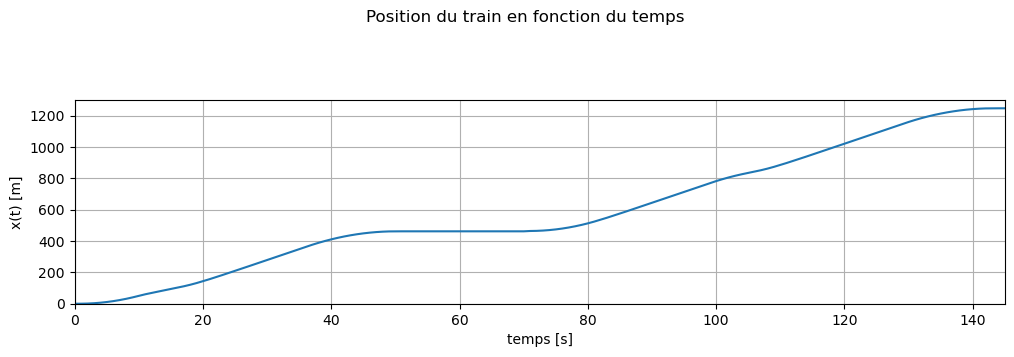

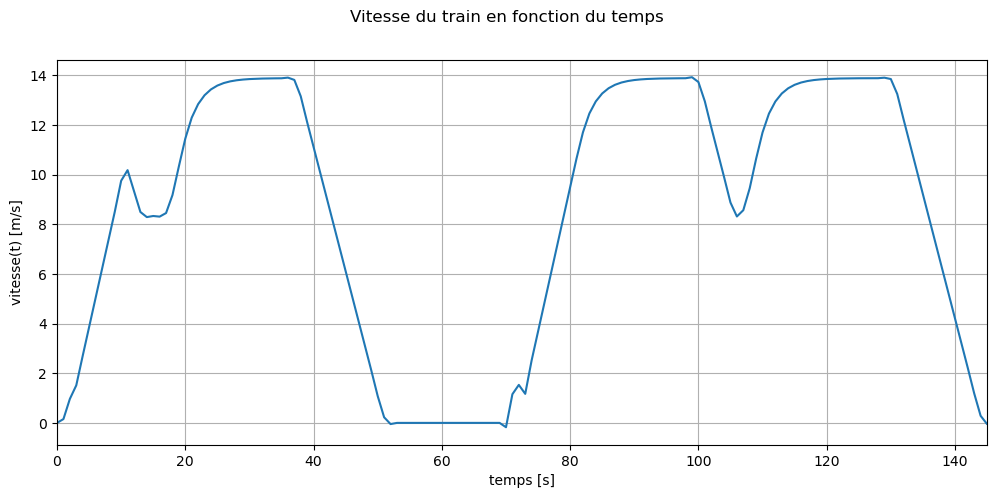

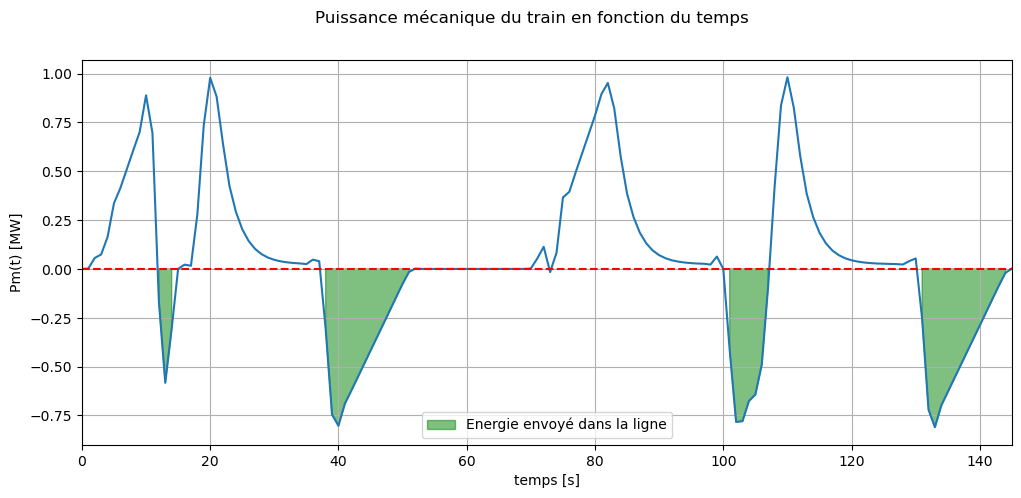

In [171]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(Times, X)
plt.grid()
plt.xlim([0,145])
plt.ylim([0,1300])
plt.ylabel("x(t) [m]")
plt.xlabel("temps [s]")
plt.suptitle("Position du train en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, V)
plt.grid()
plt.xlim([0,145])
plt.ylabel("vitesse(t) [m/s]")
plt.xlabel("temps [s]") 
plt.suptitle("Vitesse du train en fonction du temps")

plt.figure(3,figsize = (12,5))
plt.plot(Times, Pm*1e-6)
plt.plot(Times, np.zeros(len(Times)), '--', color='red')
plt.grid()
plt.xlim([0,145])
plt.fill_between(Times, Pm*1e-6, 0, where = (Pm*1e-6<=0), color = 'green', alpha = 0.5, label = 'Energie envoyé dans la ligne')
plt.legend()
plt.ylabel("Pm(t) [MW]")
plt.xlabel("temps [s]")
plt.suptitle("Puissance mécanique du train en fonction du temps")

**Commentaires :** 
   
On remarque que la puissance mécanique est négative lors des phases de freinage. Pour cette partie, il est défini que la puissance en surplus est envoyé dans la ligne, mais lorsqu'on utilisera la batterie cela ne sera pas possible, il est évident de garder cette information là lorsqu'on réfléchira à la loi de commande de notre batterie.

Nous pouvons aussi voir qu'il n'y a qu'un seul arrêt durant le trajet et deux zones de freinages durant le trajet hors arrêt complet (vers t=18s et t=108s). Ces phase sont identifiées comme propices pour la recharge de la batterie.

On remarque également qu'il y a des pics de puissance correspondant aux phases d'accélération. Ces phases sont identifiées comme prioritaires pour l'utilisation d'une batterie qui viendrait soulager la demande de puissance du train.

#### **Partie électronique** 

Calcul de RLAC1, RLAC2, Rrail1, Rrail2 en fonction de x :

In [172]:
RLAC1 = RHOLAC*X

RLAC2 = (X[-1] - X)*RHOLAC

Rrail1 = RHORAIL*X

Rrail2 = (X[-1] - X)*RHORAIL


Après simplification du schéma par le théorème de Thévenin calcul de R1, R2 et Req :

In [173]:
R1 = RSST + RLAC1 + Rrail1

R2 = RSST + RLAC2 + Rrail2

Req = (R1*R2)/(R1+R2)


Tracé des courbes des résistances en fonction du temps :

Text(0.5, 0.98, 'Résistance Req en fonction de la position')

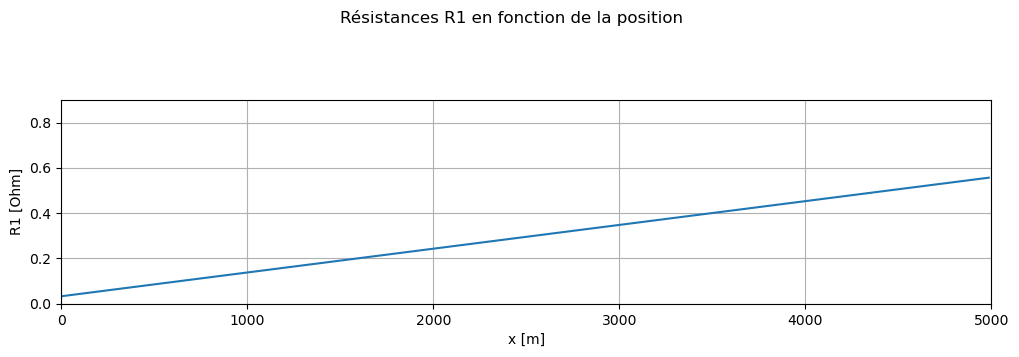

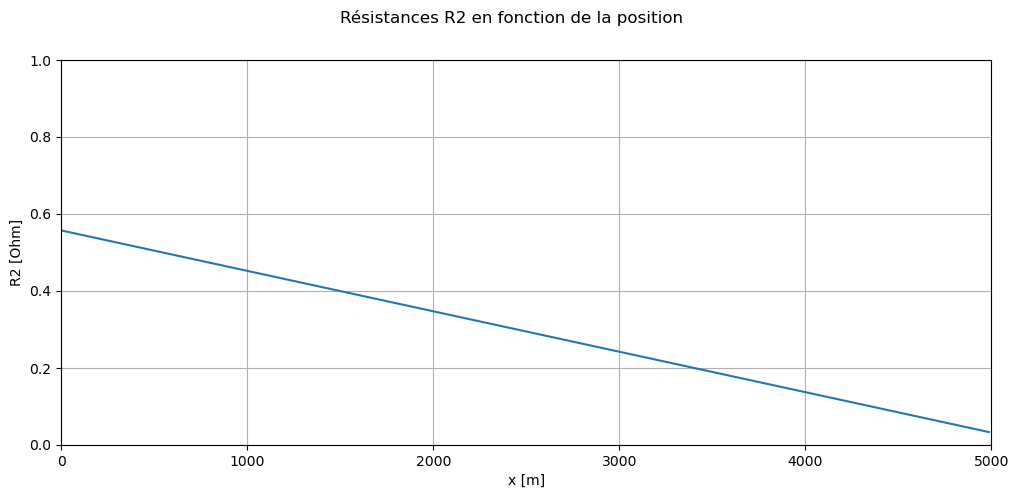

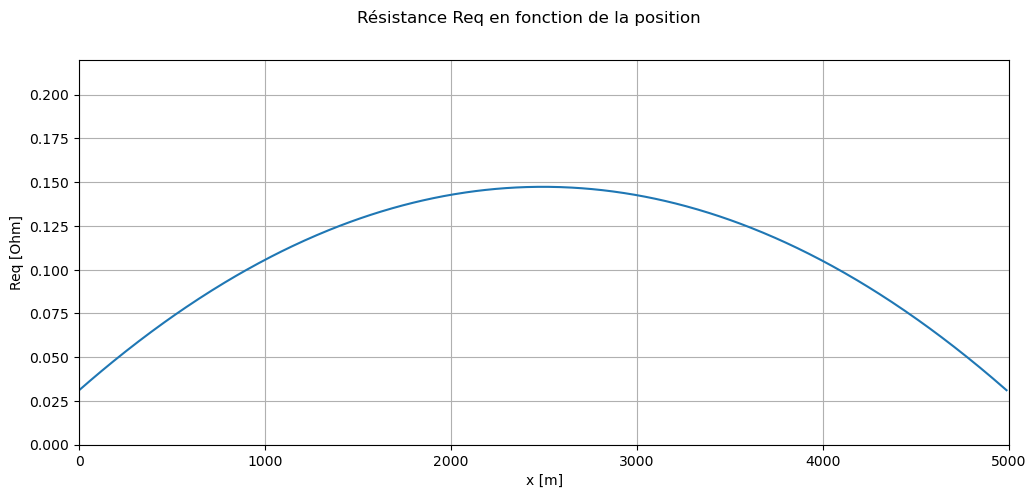

In [174]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(X, R1)
plt.grid()
plt.xlim([0,5000])
plt.ylim([0,0.9])
plt.xlabel("x [m]")
plt.ylabel("R1 [Ohm]")
plt.suptitle("Résistances R1 en fonction de la position")

plt.figure(2,figsize = (12,5))
plt.plot(X, R2)
plt.grid()
plt.xlim([0,5000])
plt.ylim([0,1])
plt.xlabel("x [m]")
plt.ylabel("R2 [Ohm]")
plt.suptitle("Résistances R2 en fonction de la position")

plt.figure(3,figsize = (12,5))
plt.plot(X, Req)
plt.grid()
plt.xlim([0,5000])
plt.ylim([0, 0.22])
plt.xlabel("x [m]")
plt.ylabel("Req [Ohm]")
plt.suptitle("Résistance Req en fonction de la position")

**Commentaires :** 
   
On remarque que, plus le train est éloigné de la sous-station 1, plus la résistance 1 est grande.
Il en est de même pour R2 par rapport à la distance de la sous-station 2.

La courbe de Req est donc logiquement une parabole avec un pic entre les 2 sous-stations. Cela implique que $R_{eq}$ est à son maximum au milieu du chemin

Calcul de PLAC :

In [175]:
PLAC = VLAC**2/(RLAC1+RLAC2)

Calcul de Vtrain :

In [176]:
for ij in range(len(X)):
    if Pm[ij]<0:
        rac = VSST**2 - 4*Req[ij]*(Pm[ij]*0.8)
    else:
        rac = VSST**2 - 4*Req[ij]*(Pm[ij]/0.8)
    rac = max(rac, 0)
    vt = (VSST + np.sqrt(rac))/2
    Vtrain.append(vt)

Vtrain = np.array(Vtrain)

**Commentaire :** 
   
Si la puissance mécanique du train est négative, on la multiplie par le rendement (0.8), ce qui signifie une perte de puissance mécanique notamment lors des phases de freinage, et inversement lorsque la puissance mécanique est positive.

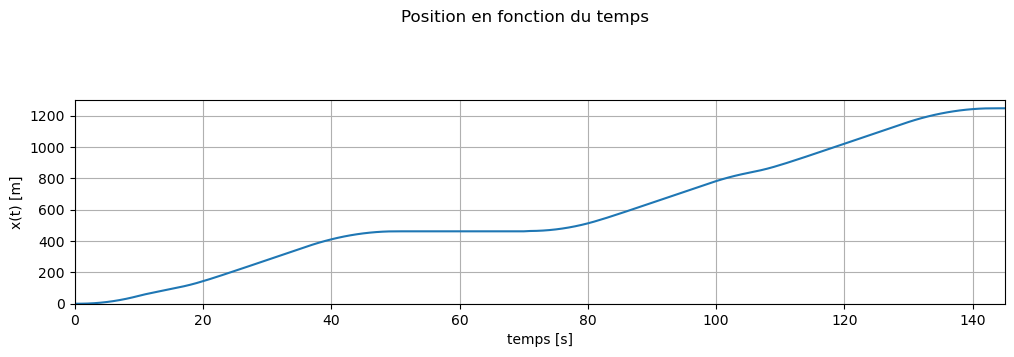

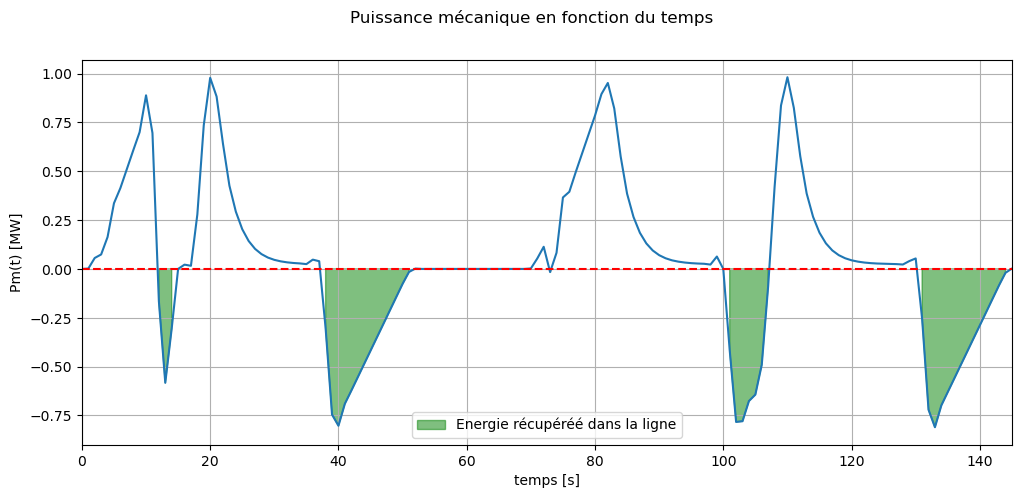

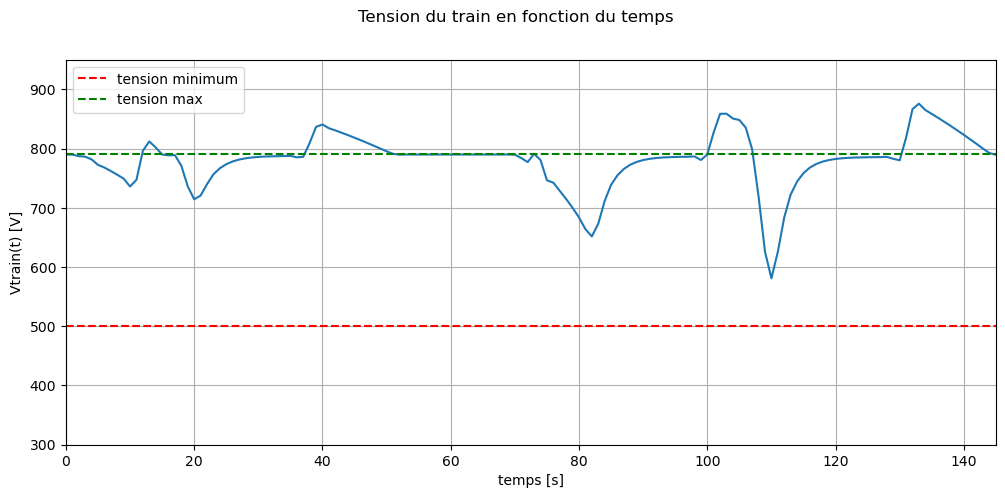

In [177]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(Times, X)
plt.grid()
plt.xlim([0,145])
plt.ylim([0,1300])
plt.xlabel("temps [s]")
plt.ylabel("x(t) [m]")
plt.suptitle("Position en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, Pm*1e-6)
plt.plot(Times, np.zeros(len(Times)), '--', color='red')
plt.grid()
plt.xlim([0,145])
plt.fill_between(Times, Pm*1e-6, 0, where = (Pm*1e-6<=0), color = 'green', alpha = 0.5, label = 'Energie récupéréé dans la ligne')
plt.legend()
plt.ylabel("Pm(t) [MW]")
plt.xlabel("temps [s]") 
plt.suptitle("Puissance mécanique en fonction du temps")

plt.figure(3,figsize = (12,5))
plt.plot(Times, Vtrain)
plt.grid()
plt.xlim([0,145])
plt.ylim([300, 950])
x = [0,145]
y = [500, 500]
y1 = [790, 790]
plt.plot(x, y, '--r', label = 'tension minimum')
plt.plot(x, y1, '--g', label = 'tension max')
plt.xlabel("temps [s]")
plt.ylabel("Vtrain(t) [V]")
plt.suptitle("Tension du train en fonction du temps")
plt.legend()

**Commentaires :**  
  
En traçant cs 3 graphiques nous pouvons analyser plusieurs points importants :
- Lorsqu'il y a un surplus d'énergie dans la ligne, la tension du train dépasse les 790V de norme. Il sera donc intéressant de profiter de ces surplus pour recharger la batterie plus tard. Ces cas se présentent lorsque le train freine.
- Sur la courbe de la tension du train nous voyons un pic en dessous de 500V, qui est dû à une forte accélération du tramway après un freinage. C'est dans ces moments précis que l'utilisation d'une batterie serait utile afin d'aider la ligne à subvenir aux besoins du train sans faire chuter la tension en dessous d'une certaine tension.
- Lors des arrêts, la puissance mécanique qui étaient négative juste avant par le freinage du tramway revient à 0W avant de redémarrer. Ce moment pourrait également être utile afin de recharger notre batterie.

Calcul de Itrain :

In [178]:
Itrain = VSST - Vtrain/Req

**Commentaires :**  

Calcul de I1 :
On sait d'après la loi des mailles que V1 - V2 = 0, donc V1 = V2, donc R1 * I1 = R2 * I2, donc I2 = (R1 * I1)/R2
D'après la loi des noeuds, I1 + I2 = Itrain, donc en remplaçant I2 par son expression en fonction de I1 on obtient :
I1 + (R1 * I1)/R2 = Itrain, donc I1(R2 + R1)/R2 = Itrain, donc I1 = (R2 * Itrain)/(R1 + R2)

In [179]:
I1 = (R2*Itrain)/(R1+R2)

Calcul de I2 :

In [180]:
I2 = (R1*I1)/R2

Text(0.5, 0.98, 'Intensités Itrain en fonction du temps')

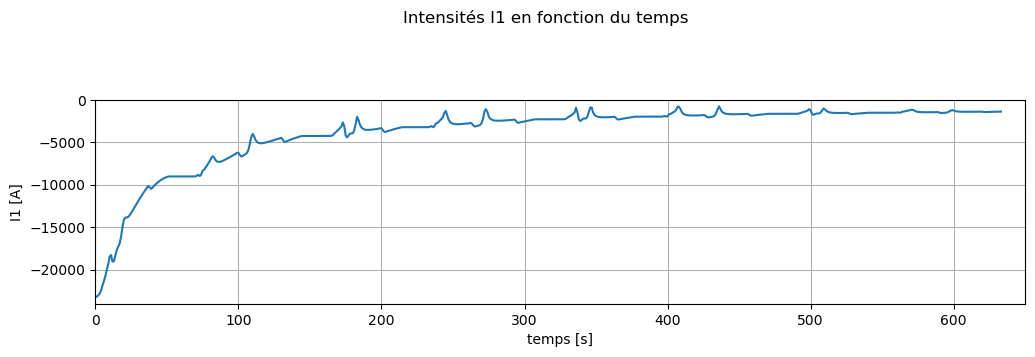

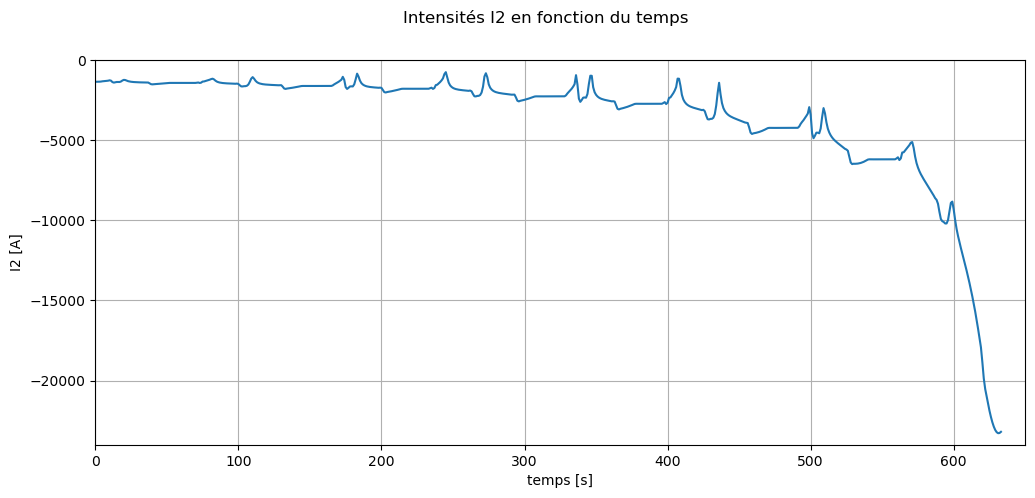

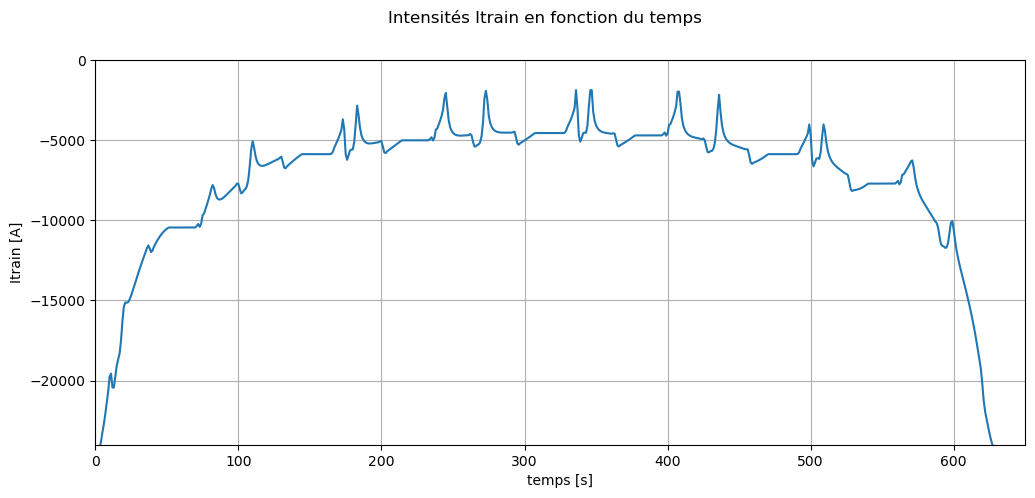

In [181]:
plt.figure(1,figsize = (12,9))
plt.subplot(3,1,1)
plt.plot(Times, I1)
plt.grid()
plt.xlim([0,650])
plt.ylim([-24000, 0])
plt.xlabel("temps [s]")
plt.ylabel("I1 [A]")
plt.suptitle("Intensités I1 en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, I2)
plt.grid()
plt.xlim([0,650])
plt.ylim([-24000, 0])
plt.xlabel("temps [s]")
plt.ylabel("I2 [A]")
plt.suptitle("Intensités I2 en fonction du temps")

plt.figure(3,figsize = (12,5))
plt.plot(Times, Itrain)
plt.grid()
plt.xlim([0,650])
plt.ylim([-24000, 0])
plt.ylabel("Itrain [A]")
plt.xlabel("temps [s]")
plt.suptitle("Intensités Itrain en fonction du temps")

Calcul de la puissance de chaque sous-station : Psst = Vsst*Isst = Vsst**2 / Rsst :

In [182]:
PSST = VSST**2 / RSST

### **2)  Système avec batterie**

Création de fonctions permettant la gestion de l'énergie de la batterie :

In [183]:
def remplissage_p_elec(pm):
    """Fonction permettant de remplir la puissance électronique nécessaire

    Args:
        pm (Array): Puissance mécanique

    Returns:
        Array: Puissance électronique
    """

    # Initialisation
    pelec = np.zeros(len(pm))

    # Remplissage de Pelec, rendement de perte 0.8
    for i in range(1, len(pm)):
        if pm[i]<=0:
            pelec[i] = pm[i]*0.8
        else:
            pelec[i] = pm[i]/0.8
    return pelec

In [184]:
def gestion_batterie(pelec,ebatt_max,seuil, req = Req, vsst = VSST, plac = PLAC):
    """Fonction calculant la gestion de la batterie pour chaque pas de temps

    Args:
        pelec (Array): Puissance électronique nécessaire
        EbattMAX (int): Capacité de la Batterie
        seuil (int): Seuil où la batterie doit intervenir
        v (Array, optional): Vitesse. Defaults to V.
        vsst (int, optional): Tension nominale. Defaults to VSST.
        plac (Array, optional): Puissance de la LAC. Defaults to PLAC.

    Returns:
        Tuple: Liste de la Tension du Train, de l'Energie de la batterie et de sa puissance
    """
    # Initialisation
    pbatt = np.zeros(len(pelec))
    ebatt = np.zeros(len(pelec))
    p_rheos = np.zeros(len(pelec))
    v_train_batt = []
    v_train_batt.append(vsst)
    ebatt0 = ebatt_max*4/4 # comment tu as choisi ca ? énoncé ?
    ebatt[0] = ebatt0
    pbatt[0] = ebatt[0]*3600
    compt_if = 0
    compt_elif = 0
    compt_else = 0

    for i in range(1, len(pelec)):
        # Loi de gestion de la batterie
        if (pelec[i]<0 ) and ebatt[i-1] <= ebatt_max: #or v[i] == 0
            compt_if += 1
            pbatt[i] = abs(pelec[i])
            ebatt[i] = ebatt[i-1] + pbatt[i]*1/3600
            if ebatt[i] > ebatt_max:
                p_rheos[i] = p_rheos[i-1] + pelec[i] + (ebatt[i]-ebatt_max)*3600
                ebatt[i] = ebatt_max
        elif pelec[i]> seuil and pbatt[i-1] > 0:
            compt_elif +=1
            pbatt[i] = ebatt[i-1] * 3600
            if pelec[i] > pbatt[i]:
                pelec[i] -= pbatt[i]
            else:
                ebatt[i] = ebatt[i-1] - pelec[i]*1/3600
                pelec[i] = 0
        else:
            compt_else += 1
            ebatt[i] = ebatt[i-1]
            pbatt[i] = pbatt[i-1]

        plac[i] = pelec[i] - pbatt[i] + p_rheos[i]
        if plac[i] < 0:
            plac[i] = 0
        # print("Pbatt =", Pbatt[i], "Ebatt =", Ebatt[i], "PLAC =", PLAC[i])
        racine = vsst**2 - 4*req[i]*(plac[i]/0.8)
        racine = max(racine,0)
        vtrain = (vsst + np.sqrt(racine))/2
        v_train_batt.append(vtrain)
        # print(VtrainBatt[i])
    # print(f'if {compt_if}, elif {compt_elif}, else {compt_else}, {np.min(v_train_batt)}')
    return v_train_batt,ebatt,pbatt

Calcul des paramètres de la batterie :

In [185]:
Pelec=remplissage_p_elec(Pm)
EbattMax = 18*1e3

Seuil = 0.5 * np.max(Pelec) # choisi par Baptiste, quel est l'unité de Pelec à discuter
VTrainBatt,EBatt,PBatt=gestion_batterie(Pelec,EbattMax,Seuil)

Calcul de l'énergie de la batterie, des puissances et de Vtrain :

Tracé des courbes de l'énergie de la batterie, de PLAC, de la puissance de la batterie et de Vtrain en fonction du temps :

Text(0.5, 0.98, 'Vtrain avec batterie en fonction du temps')

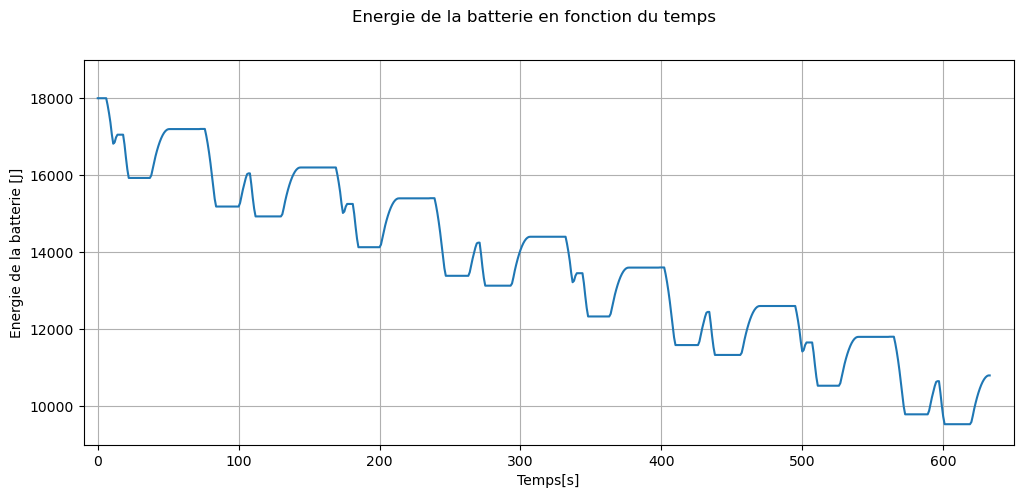

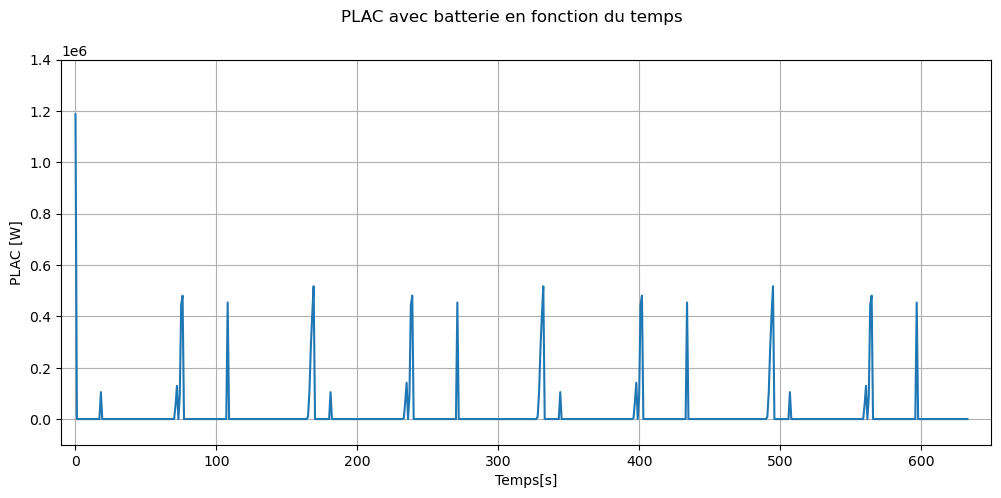

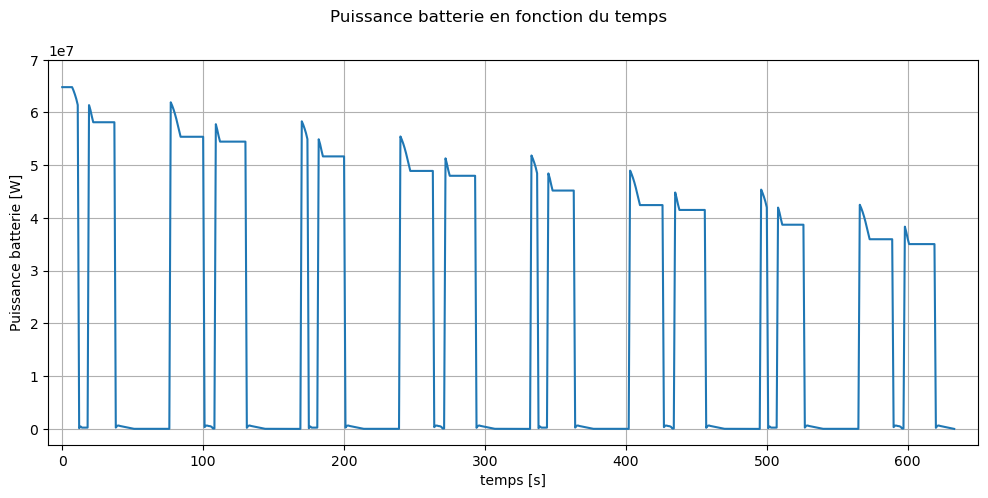

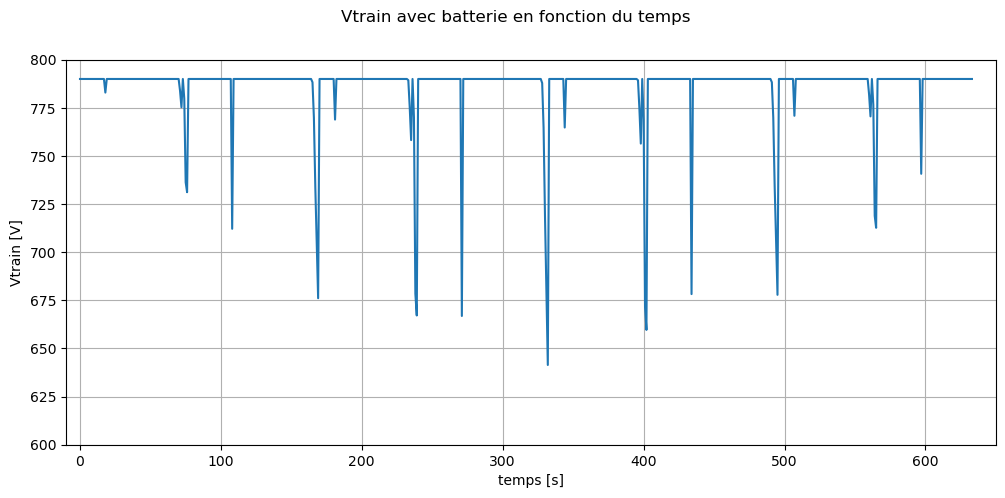

In [186]:
plt.figure(1,figsize = (12,5))
plt.plot(Times, EBatt)
plt.grid()
plt.xlim([-10, 650])
plt.ylim([9e3, 19e3])
plt.xlabel("Temps[s]")
plt.ylabel("Energie de la batterie [J]")
plt.suptitle("Energie de la batterie en fonction du temps")

plt.figure(2,figsize = (12,5))
plt.plot(Times, PLAC)
plt.grid()
plt.xlim([-10, 650])
plt.ylim([-1e5, 1.4e6])
plt.xlabel("Temps[s]")
plt.ylabel("PLAC [W]")
plt.suptitle("PLAC avec batterie en fonction du temps")

plt.figure(3,figsize = (12,5))
plt.plot(Times, PBatt)
plt.grid()
plt.xlim([-10,650])
plt.ylim([-0.3e7, 7e7])
plt.ylabel("Puissance batterie [W]")
plt.xlabel("temps [s]")
plt.suptitle("Puissance batterie en fonction du temps")

plt.figure(4,figsize = (12,5))
plt.plot(Times, VTrainBatt)
plt.grid()
plt.xlim([-10,650])
plt.ylim([600, 800])
plt.ylabel("Vtrain [V]")
plt.xlabel("temps [s]")
plt.suptitle("Vtrain avec batterie en fonction du temps")

#### **2.1) Algorithme de Monte Carlo**

Construction des solutions non dominées et de la fonction "Monte Carlo" :

In [187]:
def find_non_dominated_solution(objectif1, objectif2,nbre_simulations):
    """Fonction trouvant les solutions non-dominées

    Args:
        objectif1 (Array): Premier objectif à analyser
        objectif2 (Array): Deuxième objectif à analyser
        nbre_simulations (int): Nombre de simulation

    Returns:
        Array: Ensemble des solutions non-dominées
    """
    solutions_non_dominees = []
    for i in range(nbre_simulations):
        is_dominated = False
        for j in range(nbre_simulations):
            if (objectif1[j] <= objectif1[i] and objectif2[j] <= objectif2[i] and
                (objectif1[j] < objectif1[i] or objectif2[j] < objectif2[i])):
                is_dominated = True
                break
        if not is_dominated:
            solutions_non_dominees.append(i)

    return solutions_non_dominees

In [188]:
def monte_carlo(nbre_simulations,capacite_batterie_random,seuil_random,pelec, vsst = VSST, placc = PLAC, vlac = VLAC, rlac1 = RLAC1, rlac2 = RLAC2):
    """Fonction de Monte-Carlo

    Args:
        nbre_simulations (int): Le nombre de simulation
        capacite_batterie_random (Array): Liste des différentes tailles de Capacité de la batterie
        seuil_random (Array): Liste des différents seuils de quand la batterie s'active
        pelec (Araay): Puissance électronique demandé en chaque point

    Returns:
        Tuple: La liste de la chute de tension max pour chaque essai et la liste des capacités
    """
    dv_max =[]
    for i in range(nbre_simulations):
        pelecc = remplissage_p_elec(Pm)
        placc = vlac**2/(rlac1+rlac2)
        vtrainbatt, _, _ = gestion_batterie(pelecc, capacite_batterie_random[i], seuil_random[i], plac = placc)
        dv_max.append(vsst - min(vtrainbatt))
    return dv_max

Définition des solutions aléatoires et du seuil pour la chute de tension maximale :

In [189]:
# Capacité de la batterie (en kWh) objectif1
Capacite_batterie_random=  np.random.uniform(0, 200000, NB_SIMU)

# Chute de tension maximale (en MW) objectif2
Seuil_random = np.random.uniform(0, 1e6, NB_SIMU)

Calcul des solutions par l'algorithme de Monte Carlo et identification des solutions non dominées :

In [190]:
dV_max=monte_carlo(NB_SIMU,Capacite_batterie_random,Seuil_random,Pelec)
Solutions_non_dominees=find_non_dominated_solution(Capacite_batterie_random ,dV_max,NB_SIMU)


Affichage des solutions :

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


'"\n\nplt.subplot(211)\nplt.scatter(Capacite_batterie_random, Seuil_random, color = \'skyblue\')\n# plt.scatter(capacite_correcte,seuil_correcte,color=\'red\')\nfor ii, sol in enumerate(Solutions_non_dominees):\n    plt.scatter(Capacite_batterie_random[sol],\n                Seuil_random[sol], color=\'red\')\nplt.xlabel(\'Capacité en énergie de la batterie (kWh)\')\nplt.ylabel(\'P seuil (MW)\')\nplt.title(\'Espace des solutions / de recherche\')\nplt.grid()\nplt.legend()\n\n\nplt.subplot(212)\nplt.scatter(Capacite_batterie_random, dV_max, color = \'skyblue\')\nfor ii, sol in enumerate(Solutions_non_dominees):\n    plt.scatter(Capacite_batterie_random[sol],\n                dV_max[sol], color=\'red\')\nplt.xlabel(\'Capacité en énergie de la batterie (kWh)\')\nplt.ylabel(\'dV max (V)\')\nplt.title(\'Espace des objectifs\')\nplt.grid()\nplt.legend()\n\n\nplt.tight_layout()\nplt.show()\n'

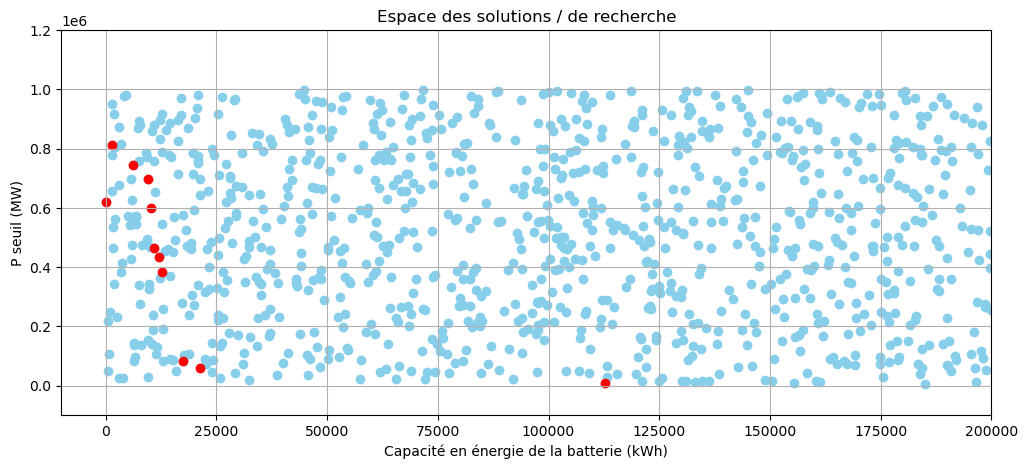

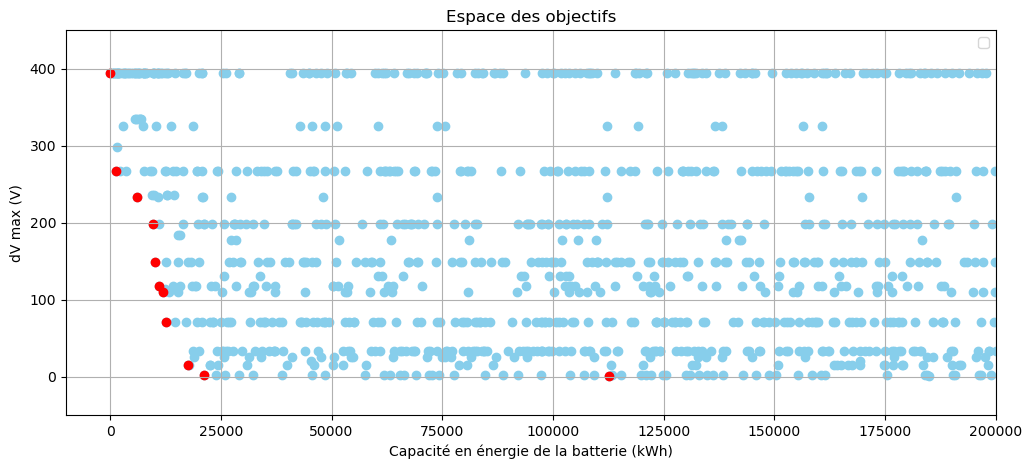

In [191]:
plt.figure(1,figsize = (12,5))
plt.scatter(Capacite_batterie_random, Seuil_random, color = 'skyblue')
for ii, sol in enumerate(Solutions_non_dominees):
    plt.scatter(Capacite_batterie_random[sol],
                Seuil_random[sol], color='red')
plt.grid()
plt.xlim([-10000, 200000])
plt.ylim([-0.1e6, 1.2e6])
plt.xlabel('Capacité en énergie de la batterie (kWh)')
plt.ylabel('P seuil (MW)')
plt.title('Espace des solutions / de recherche')

plt.figure(2,figsize = (12,5))
plt.scatter(Capacite_batterie_random, dV_max, color = 'skyblue')
for ii, sol in enumerate(Solutions_non_dominees):
    plt.scatter(Capacite_batterie_random[sol],
                dV_max[sol], color='red')
plt.xlim([-10000, 200000])
plt.ylim([-50, 450])
plt.xlabel('Capacité en énergie de la batterie (kWh)')
plt.ylabel('dV max (V)')
plt.title('Espace des objectifs')
plt.grid()
plt.legend()

""""

plt.subplot(211)
plt.scatter(Capacite_batterie_random, Seuil_random, color = 'skyblue')
# plt.scatter(capacite_correcte,seuil_correcte,color='red')
for ii, sol in enumerate(Solutions_non_dominees):
    plt.scatter(Capacite_batterie_random[sol],
                Seuil_random[sol], color='red')
plt.xlabel('Capacité en énergie de la batterie (kWh)')
plt.ylabel('P seuil (MW)')
plt.title('Espace des solutions / de recherche')
plt.grid()
plt.legend()


plt.subplot(212)
plt.scatter(Capacite_batterie_random, dV_max, color = 'skyblue')
for ii, sol in enumerate(Solutions_non_dominees):
    plt.scatter(Capacite_batterie_random[sol],
                dV_max[sol], color='red')
plt.xlabel('Capacité en énergie de la batterie (kWh)')
plt.ylabel('dV max (V)')
plt.title('Espace des objectifs')
plt.grid()
plt.legend()


plt.tight_layout()
plt.show()
"""

**Commentaires :**

Le front de Pareto apparaît en rouge avec les solutions non dominées.

#### **2.2) Résolution par algorithme génétique**

Notes: Objectif: trouver un enssemble de solutions non-dominées appelées Paréto optimales. Identification de front de paréto 
-> ensemble de solutions où aucune solution ne peut être améliorée dans un objectif sans détériorer un autre objectif.
1) Population N choisis aléatoirement
2) Individu --> gènes , enssemble des gènes de l'inidividu --> chromosome
3) À chaque génération (nombre de génération choisi préalablement) : 
- calcul du rang des individus : le premier rang contient les solutions non dominées( Paréto optimales), le second rang contient les solutions dominées uniquement par celles du premier rang, et ainsi de suite.
- 50% de cette population initiale est ensuite sélectionné parmi les meilleurs (on retient donc le rang1, le rang2... jusqu'à obtenir 50% de la population). Ces 50% sélectionnés représentent la population P1
- Parmi P1, on en sélectionne la moitié de façon aléatoire et on créé des enfants en croisant ces individus sélectionnés.
- On complète en créant de enfants à partir de mutation des individus avec la moitié restante de P1.
4) Arret à la fin du cycle de génération


3 caractéristiques suivantes:  

- Principe de l'éllitsime  
- Favorise les solutions non dominées  
- Donc, dévloppe une grande variété de solution


Ref:
https://www.mechanics-industry.org/articles/meca/pdf/2010/03/mi100066.pdf
https://moodle-sciences-24.sorbonne-universite.fr/pluginfile.php/227541/mod_resource/content/1/142199_BOUKIR%20_2023_archivage.pdf THESE
https://moodle-sciences-24.sorbonne-universite.fr/pluginfile.php/225975/mod_resource/content/1/OPTIM_2425_Presentation_projet.pdf SLIDE
"""

Notes de la thèse: 
Explorer les zones qui paraissent prometteuses sans être bloquées
par un optimum local.

Définition de la fonction NGSA2 :

In [192]:
def NGSA2(capacite_batterie,chute_tension,nb_generation,pop_size):
    # Initialisation
    population = np.column_stack((capacite_batterie, chute_tension))# poppulation individu "parent" initial généré aléatoirement taille N
    Q=[] # enssemble des "enfants" pour chaque generation
    P=[] # enssemble des "parents" pour chaque generation
    R=[] # enssemble créé avec parents + enfants donc de taille 2*N


    fronts_pareto=[]


    for i in range(nb_generation):
        # front de pareto
        o1=[]
        o2=[]
        for i in population:
            o1.append(i[0])
            o2.append(i[1])
        front=find_non_dominated_solution(o1,o2,pop_size) # c'est notre fonction d'évaluation!!!!!
        fronts_pareto.append(front)
        # selection (50% + distance d'emcombrement) distance d'encombrement à rajouter


Définition des paramètres pour l'algorithme NGSA2 :

In [193]:
POP_SIZE=1000
Capacite_batterie = np.random.uniform(0, 200000, POP_SIZE)  # Capacité de la batterie (en kWh) objectif1
Chute_tension = np.random.uniform(0, 1e6, POP_SIZE)  # Chute de tension maximale (en V) objectif2  

Création d'une fonction permettant de "ranger" les individus : 

In [ ]:
def rang(capacite_batterie, chute_tension, dv_max):
    Cap_batt = []
    Cap_batt.append(capacite_batterie.copy())
    Chu_tension = []
    Chu_tension.append(chute_tension.copy())
    dv = []
    dv.append(dv_max.copy())
    rang_list = []

    while Cap_batt[-1].size > 0:
        test = find_non_dominated_solution(Cap_batt[-1], dv[-1],len(Cap_batt[-1]))
        print(test)
        rang_list.append(test)
        Cap_batt.append(np.delete(Cap_batt[-1], rang_list[-1]))
        Chu_tension.append(np.delete(Chu_tension[-1], rang_list[-1]))
        dv.append(np.delete(dv[-1], rang_list[-1]))

    print(rang_list)

    return rang_list, Cap_batt, Chu_tension, dv

Définition d'une fonction permettant de créer des enfants par mutation :

In [195]:
def mutation(individual,variable_limite, mutation_rate=0.5): 
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.uniform(variable_limite[0],variable_limite[1])  # changement s'opère entre les limites, mutations aleatoire 
    return individual

Définition d'une fonction permettant de créer des enfants par croisement :

In [196]:
def croisement(parent1, parent2, rate=0.5): # le rate 0.5 signifie une chance égale , 50% des cas --> croisement réalisé
    taille_genome = len(parent1)
    enfant=[]
    # for i in range(taille_genome):
    if random.random() < rate: # génére un nb entre 0 et 1 # a mettre la , ou leurs de l'appel de la fonction à voir plus tard
        point_de_croisement= random.randint(0,taille_genome-1)
        enfant= parent1[:point_de_croisement] + parent2[point_de_croisement:]        

    return enfant

Définition d'une fonction permettant sélectionner des individus :

In [197]:
def selection(fronts_pareto,distances,pop_size):
    # il faut selectionner 50% des meilleurs d'après le slide du projet
    selected=[]
    N=int(pop_size*0.5)  # nomrbe_a_selectionne
    for i in range(0,len(fronts_pareto)):
        if len(selected) + len(fronts_pareto[i]) < N:
            selected.extend(fronts_pareto[i])
        else:
            reste= N-len(selected) 
            front= fronts_pareto[i]
            if reste>0:
                selected.extend(front[:reste])
            break
         
    return selected